In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../../data/val_1/skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

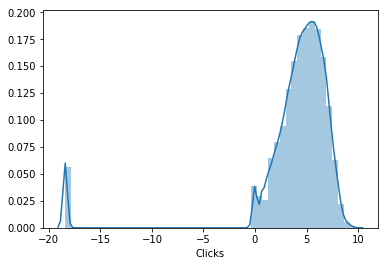

In [3]:
sns.distplot(np.log(df_train_Y['Clicks'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Clicks']:
    df_train_Y['Clicks_log'] = df_train_Y['Clicks'].apply(log)
    df_val_Y['Clicks_log'] = df_val_Y['Clicks'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Clicks_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Clicks_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Clicks'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.49778858814503546, 'colsample_bytree': 0.75, 'gamma': 0.0017686929133595044, 'lambda': 3.6283152208524223, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 0.18988168286106574, 'n_estimators': 760.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:4.74239	eval-rmse:4.26389                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.09835	eval-rmse:3.54902                                                                               

[2]	train-rmse:3.64219	eval-rmse:3.03921                                                                         

[11]	train-rmse:2.36502	eval-rmse:2.20356                                                                              

[12]	train-rmse:2.34813	eval-rmse:2.20244                                                                              

[13]	train-rmse:2.32183	eval-rmse:2.23983                                                                              

[14]	train-rmse:2.30293	eval-rmse:2.24568                                                                              

[15]	train-rmse:2.28787	eval-rmse:2.24333                                                                              

[16]	train-rmse:2.27847	eval-rmse:2.27485                                                                              

[17]	train-rmse:2.26392	eval-rmse:2.28961                                                                              

[18]	train-rmse:2.23856	eval-rmse:2.30099                                                                              

[19]	train-rmse:2.22401	eval-rms

[4]	train-rmse:3.42326	eval-rmse:2.96053                                                                               

[5]	train-rmse:3.19876	eval-rmse:2.73835                                                                               

[6]	train-rmse:3.01709	eval-rmse:2.56843                                                                               

[7]	train-rmse:2.87068	eval-rmse:2.43977                                                                               

[8]	train-rmse:2.75496	eval-rmse:2.34612                                                                               

[9]	train-rmse:2.66418	eval-rmse:2.2721                                                                                

[10]	train-rmse:2.58613	eval-rmse:2.21945                                                                              

[11]	train-rmse:2.52519	eval-rmse:2.17481                                                                              

[12]	train-rmse:2.47746	eval-rms

[40]	train-rmse:2.84422	eval-rmse:2.06549                                                                              

[41]	train-rmse:2.84131	eval-rmse:2.06439                                                                              

[42]	train-rmse:2.83919	eval-rmse:2.06444                                                                              

[43]	train-rmse:2.8373	eval-rmse:2.06458                                                                               

[44]	train-rmse:2.83504	eval-rmse:2.06934                                                                              

[45]	train-rmse:2.83155	eval-rmse:2.06815                                                                              

[46]	train-rmse:2.82966	eval-rmse:2.06857                                                                              

[47]	train-rmse:2.82818	eval-rmse:2.06923                                                                              

[48]	train-rmse:2.82602	eval-rms

[12]	train-rmse:2.51423	eval-rmse:2.13577                                                                              

[13]	train-rmse:2.49616	eval-rmse:2.13468                                                                              

[14]	train-rmse:2.48747	eval-rmse:2.13703                                                                              

[15]	train-rmse:2.46613	eval-rmse:2.14359                                                                              

[16]	train-rmse:2.46006	eval-rmse:2.14376                                                                              

[17]	train-rmse:2.44448	eval-rmse:2.14121                                                                              

[18]	train-rmse:2.43317	eval-rmse:2.15087                                                                              

[19]	train-rmse:2.41027	eval-rmse:2.14577                                                                              

[20]	train-rmse:2.40053	eval-rms

[44]	train-rmse:2.87161	eval-rmse:2.05965                                                                              

[45]	train-rmse:2.86901	eval-rmse:2.05807                                                                              

[46]	train-rmse:2.86728	eval-rmse:2.05845                                                                              

[47]	train-rmse:2.86386	eval-rmse:2.05863                                                                              

[48]	train-rmse:2.86165	eval-rmse:2.05816                                                                              

[49]	train-rmse:2.85942	eval-rmse:2.0589                                                                               

[50]	train-rmse:2.85777	eval-rmse:2.05789                                                                              

[51]	train-rmse:2.85542	eval-rmse:2.05788                                                                              

[52]	train-rmse:2.85338	eval-rms

[2]	train-rmse:3.13461	eval-rmse:2.65817                                                                               

[3]	train-rmse:2.8416	eval-rmse:2.39368                                                                                

[4]	train-rmse:2.66255	eval-rmse:2.25318                                                                               

[5]	train-rmse:2.55131	eval-rmse:2.19432                                                                               

[6]	train-rmse:2.47017	eval-rmse:2.15829                                                                               

[7]	train-rmse:2.41917	eval-rmse:2.14198                                                                               

[8]	train-rmse:2.37474	eval-rmse:2.13385                                                                               

[9]	train-rmse:2.35011	eval-rmse:2.13693                                                                               

[10]	train-rmse:2.31056	eval-rms


loss: 97326583.0878804                                                                                                 
Training with params:                                                                                                  
{'alpha': 5.857773278895302e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.4903730069813082e-07, 'lambda': 3.0614580869365123e-06, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 6.7138898451276265, 'n_estimators': 770.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.23188	eval-rmse:4.80172                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.86342	eval-rmse:4.40803                                                       

[10]	train-rmse:2.35257	eval-rmse:2.098                                                                                

[11]	train-rmse:2.32944	eval-rmse:2.11834                                                                              

[12]	train-rmse:2.30128	eval-rmse:2.12034                                                                              

[13]	train-rmse:2.27914	eval-rmse:2.11675                                                                              

[14]	train-rmse:2.26675	eval-rmse:2.13648                                                                              

[15]	train-rmse:2.24481	eval-rmse:2.15245                                                                              

[16]	train-rmse:2.22486	eval-rmse:2.18311                                                                              

[17]	train-rmse:2.20287	eval-rmse:2.18704                                                                              

[18]	train-rmse:2.18146	eval-rms

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.16157	eval-rmse:2.05656


loss: 97435505.43103082                                                                                                
Training with params:                                                                                                  
{'alpha': 1.6142369975444712e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.1360706718182708e-07, 'lambda': 0.001359151164368664, 'learning_rate': 0.42500000000000004, 'max_depth': 9, 'min_child_weight': 0.6774816946774024, 'n_estimators': 1000.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:3.9011	eval-rmse:3.47944                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't imp

[18]	train-rmse:4.02612	eval-rmse:3.61313                                                                              

[19]	train-rmse:3.96291	eval-rmse:3.55195                                                                              

[20]	train-rmse:3.90139	eval-rmse:3.49208                                                                              

[21]	train-rmse:3.84349	eval-rmse:3.4338                                                                               

[22]	train-rmse:3.78679	eval-rmse:3.37846                                                                              

[23]	train-rmse:3.73161	eval-rmse:3.32492                                                                              

[24]	train-rmse:3.67772	eval-rmse:3.27278                                                                              

[25]	train-rmse:3.62611	eval-rmse:3.22377                                                                              

[26]	train-rmse:3.5758	eval-rmse

[6]	train-rmse:2.8052	eval-rmse:2.42734                                                                                

[7]	train-rmse:2.66443	eval-rmse:2.32932                                                                               

[8]	train-rmse:2.56174	eval-rmse:2.25683                                                                               

[9]	train-rmse:2.48561	eval-rmse:2.20144                                                                               

[10]	train-rmse:2.41954	eval-rmse:2.16756                                                                              

[11]	train-rmse:2.35829	eval-rmse:2.14584                                                                              

[12]	train-rmse:2.31359	eval-rmse:2.13002                                                                              

[13]	train-rmse:2.26556	eval-rmse:2.12014                                                                              

[14]	train-rmse:2.23242	eval-rms

[8]	train-rmse:2.44469	eval-rmse:2.16063                                                                               

[9]	train-rmse:2.40873	eval-rmse:2.16156                                                                               

[10]	train-rmse:2.375	eval-rmse:2.17109                                                                                

[11]	train-rmse:2.36555	eval-rmse:2.17305                                                                              

[12]	train-rmse:2.33494	eval-rmse:2.16462                                                                              

[13]	train-rmse:2.30929	eval-rmse:2.20185                                                                              

[14]	train-rmse:2.28419	eval-rmse:2.20511                                                                              

[15]	train-rmse:2.25907	eval-rmse:2.20876                                                                              

[16]	train-rmse:2.23346	eval-rms

[26]	train-rmse:2.78676	eval-rmse:2.08296                                                                              

[27]	train-rmse:2.78231	eval-rmse:2.09059                                                                              

[28]	train-rmse:2.77838	eval-rmse:2.09643                                                                              

[29]	train-rmse:2.77384	eval-rmse:2.08765                                                                              

[30]	train-rmse:2.77118	eval-rmse:2.08674                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.86781	eval-rmse:2.07736


loss: 98659831.06967725                                                                                                
Training with params:                                                                                          

[23]	train-rmse:2.71188	eval-rmse:2.07376                                                                              

[24]	train-rmse:2.70961	eval-rmse:2.07698                                                                              

[25]	train-rmse:2.70542	eval-rmse:2.0743                                                                               

[26]	train-rmse:2.70215	eval-rmse:2.0784                                                                               

[27]	train-rmse:2.69845	eval-rmse:2.08204                                                                              

[28]	train-rmse:2.69211	eval-rmse:2.08963                                                                              

[29]	train-rmse:2.68802	eval-rmse:2.09219                                                                              

[30]	train-rmse:2.68627	eval-rmse:2.08985                                                                              

[31]	train-rmse:2.68244	eval-rms

[45]	train-rmse:2.76849	eval-rmse:2.05666                                                                              

[46]	train-rmse:2.76532	eval-rmse:2.06066                                                                              

[47]	train-rmse:2.76331	eval-rmse:2.06239                                                                              

[48]	train-rmse:2.76217	eval-rmse:2.06454                                                                              

[49]	train-rmse:2.75884	eval-rmse:2.06512                                                                              

[50]	train-rmse:2.75705	eval-rmse:2.06593                                                                              

[51]	train-rmse:2.75614	eval-rmse:2.0654                                                                               

[52]	train-rmse:2.75268	eval-rmse:2.06254                                                                              

[53]	train-rmse:2.75093	eval-rms

[67]	train-rmse:2.23311	eval-rmse:2.05082                                                                              

[68]	train-rmse:2.22952	eval-rmse:2.05064                                                                              

[69]	train-rmse:2.22307	eval-rmse:2.05076                                                                              

[70]	train-rmse:2.21798	eval-rmse:2.0504                                                                               

[71]	train-rmse:2.21364	eval-rmse:2.05096                                                                              

[72]	train-rmse:2.20932	eval-rmse:2.05038                                                                              

[73]	train-rmse:2.20388	eval-rmse:2.05077                                                                              

[74]	train-rmse:2.19689	eval-rmse:2.05081                                                                              

[75]	train-rmse:2.19168	eval-rms

[36]	train-rmse:2.10982	eval-rmse:2.11374                                                                              

[37]	train-rmse:2.09605	eval-rmse:2.11463                                                                              

[38]	train-rmse:2.07368	eval-rmse:2.12445                                                                              

Stopping. Best iteration:                                                                                              
[18]	train-rmse:2.34465	eval-rmse:2.0857


loss: 97142862.4264425                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.3000187777399792, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0006110225009018853, 'lambda': 5.521490460845081e-05, 'learning_rate': 0.275, 'max_depth': 7, 'min_child_weight': 5.8107139046268665, 'n_estimators': 824

[25]	train-rmse:2.00594	eval-rmse:2.27785                                                                              

[26]	train-rmse:1.99464	eval-rmse:2.27731                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.44469	eval-rmse:2.11951


loss: 96952196.2228397                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.043077539042919985, 'colsample_bytree': 0.9, 'gamma': 1.1500799671620507e-05, 'lambda': 1.0569404317432677e-05, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 4.830563864217787, 'n_estimators': 367.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.14895	eval-rmse:3.55163                                               

[25]	train-rmse:2.39863	eval-rmse:2.20258                                                                              

[26]	train-rmse:2.39366	eval-rmse:2.206                                                                                

[27]	train-rmse:2.38862	eval-rmse:2.21205                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:2.6633	eval-rmse:2.0902


loss: 97718266.79571615                                                                                                
Training with params:                                                                                                  
{'alpha': 0.951840974042153, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.00019349188507666689, 'lambda': 0.0007901035992121819, 'learning_rate': 0.45, 'max_depth': 8, 'min_child_weight': 7.942803532442134, 'n_estimators': 234.0, 

[48]	train-rmse:2.69143	eval-rmse:2.0408                                                                               

[49]	train-rmse:2.68812	eval-rmse:2.04194                                                                              

[50]	train-rmse:2.68524	eval-rmse:2.04132                                                                              

[51]	train-rmse:2.68148	eval-rmse:2.04216                                                                              

[52]	train-rmse:2.67771	eval-rmse:2.04166                                                                              

[53]	train-rmse:2.67356	eval-rmse:2.04383                                                                              

[54]	train-rmse:2.66876	eval-rmse:2.04324                                                                              

[55]	train-rmse:2.66596	eval-rmse:2.04518                                                                              

[56]	train-rmse:2.66385	eval-rms

[4]	train-rmse:2.8695	eval-rmse:2.09552                                                                                

[5]	train-rmse:2.84442	eval-rmse:2.10225                                                                               

[6]	train-rmse:2.8259	eval-rmse:2.10157                                                                                

[7]	train-rmse:2.81374	eval-rmse:2.10231                                                                               

[8]	train-rmse:2.80042	eval-rmse:2.10194                                                                               

[9]	train-rmse:2.79486	eval-rmse:2.10447                                                                               

[10]	train-rmse:2.78424	eval-rmse:2.11043                                                                              

[11]	train-rmse:2.77696	eval-rmse:2.11223                                                                              

[12]	train-rmse:2.76293	eval-rms

[24]	train-rmse:2.11397	eval-rmse:2.09145                                                                              

[25]	train-rmse:2.09862	eval-rmse:2.09092                                                                              

[26]	train-rmse:2.08373	eval-rmse:2.09308                                                                              

[27]	train-rmse:2.06577	eval-rmse:2.0927                                                                               

[28]	train-rmse:2.05481	eval-rmse:2.08932                                                                              

[29]	train-rmse:2.04305	eval-rmse:2.09011                                                                              

[30]	train-rmse:2.02658	eval-rmse:2.08882                                                                              

[31]	train-rmse:2.00776	eval-rmse:2.09096                                                                              

[32]	train-rmse:1.99626	eval-rms

[44]	train-rmse:2.24092	eval-rmse:2.1161                                                                               

[45]	train-rmse:2.22569	eval-rmse:2.1112                                                                               

[46]	train-rmse:2.21237	eval-rmse:2.10602                                                                              

[47]	train-rmse:2.19901	eval-rmse:2.10209                                                                              

[48]	train-rmse:2.18654	eval-rmse:2.09931                                                                              

[49]	train-rmse:2.17351	eval-rmse:2.09355                                                                              

[50]	train-rmse:2.16074	eval-rmse:2.09125                                                                              

[51]	train-rmse:2.15037	eval-rmse:2.08758                                                                              

[52]	train-rmse:2.13887	eval-rms

[4]	train-rmse:2.96383	eval-rmse:2.61006                                                                               

[5]	train-rmse:2.74723	eval-rmse:2.43376                                                                               

[6]	train-rmse:2.58821	eval-rmse:2.3028                                                                                

[7]	train-rmse:2.46857	eval-rmse:2.22572                                                                               

[8]	train-rmse:2.3817	eval-rmse:2.17321                                                                                

[9]	train-rmse:2.32638	eval-rmse:2.14398                                                                               

[10]	train-rmse:2.26339	eval-rmse:2.12671                                                                              

[11]	train-rmse:2.21499	eval-rmse:2.11563                                                                              

[12]	train-rmse:2.17825	eval-rms

[23]	train-rmse:1.63432	eval-rmse:2.2733                                                                               

[24]	train-rmse:1.60474	eval-rmse:2.27675                                                                              

[25]	train-rmse:1.5723	eval-rmse:2.28689                                                                               

[26]	train-rmse:1.54556	eval-rmse:2.29669                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.23204	eval-rmse:2.16278


loss: 96823859.27697082                                                                                                
Training with params:                                                                                                  
{'alpha': 0.010924799596683276, 'colsample_bytree': 0.75, 'gamma': 1.1823383367040667e-06, 'lambda': 0.0012881843

[17]	train-rmse:2.09987	eval-rmse:2.12104                                                                              

[18]	train-rmse:2.06902	eval-rmse:2.12141                                                                              

[19]	train-rmse:2.04879	eval-rmse:2.12255                                                                              

[20]	train-rmse:2.03492	eval-rmse:2.12377                                                                              

[21]	train-rmse:2.01773	eval-rmse:2.12553                                                                              

[22]	train-rmse:1.99339	eval-rmse:2.1312                                                                               

[23]	train-rmse:1.96683	eval-rmse:2.13039                                                                              

[24]	train-rmse:1.95148	eval-rmse:2.13                                                                                 

[25]	train-rmse:1.9383	eval-rmse

[26]	train-rmse:2.78671	eval-rmse:2.06062                                                                              

[27]	train-rmse:2.78064	eval-rmse:2.06051                                                                              

[28]	train-rmse:2.77759	eval-rmse:2.06053                                                                              

[29]	train-rmse:2.77381	eval-rmse:2.06352                                                                              

[30]	train-rmse:2.77079	eval-rmse:2.06705                                                                              

[31]	train-rmse:2.76942	eval-rmse:2.0659                                                                               

[32]	train-rmse:2.76772	eval-rmse:2.06468                                                                              

[33]	train-rmse:2.76429	eval-rmse:2.05862                                                                              

[34]	train-rmse:2.75997	eval-rms

[43]	train-rmse:2.7554	eval-rmse:2.03843                                                                               

[44]	train-rmse:2.75348	eval-rmse:2.03815                                                                              

[45]	train-rmse:2.7518	eval-rmse:2.03803                                                                               

[46]	train-rmse:2.75103	eval-rmse:2.0371                                                                               

[47]	train-rmse:2.74887	eval-rmse:2.03669                                                                              

[48]	train-rmse:2.74447	eval-rmse:2.0377                                                                               

[49]	train-rmse:2.74233	eval-rmse:2.03811                                                                              

[50]	train-rmse:2.73873	eval-rmse:2.03867                                                                              

[51]	train-rmse:2.73583	eval-rms

[26]	train-rmse:2.56397	eval-rmse:2.16819                                                                              

[27]	train-rmse:2.55519	eval-rmse:2.17034                                                                              

[28]	train-rmse:2.54852	eval-rmse:2.16921                                                                              

[29]	train-rmse:2.54443	eval-rmse:2.17796                                                                              

[30]	train-rmse:2.54041	eval-rmse:2.1852                                                                               

[31]	train-rmse:2.52805	eval-rmse:2.16932                                                                              

[32]	train-rmse:2.52412	eval-rmse:2.17003                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.69654	eval-rmse

[6]	train-rmse:2.61521	eval-rmse:2.13055                                                                               

[7]	train-rmse:2.55927	eval-rmse:2.11066                                                                               

[8]	train-rmse:2.52407	eval-rmse:2.10187                                                                               

[9]	train-rmse:2.48796	eval-rmse:2.08586                                                                               

[10]	train-rmse:2.46784	eval-rmse:2.08678                                                                              

[11]	train-rmse:2.4392	eval-rmse:2.09182                                                                               

[12]	train-rmse:2.42262	eval-rmse:2.103                                                                                

[13]	train-rmse:2.40549	eval-rmse:2.10705                                                                              

[14]	train-rmse:2.37578	eval-rms

[23]	train-rmse:2.50079	eval-rmse:2.0531                                                                               

[24]	train-rmse:2.49408	eval-rmse:2.05303                                                                              

[25]	train-rmse:2.48897	eval-rmse:2.05547                                                                              

[26]	train-rmse:2.48336	eval-rmse:2.06067                                                                              

[27]	train-rmse:2.46926	eval-rmse:2.05469                                                                              

[28]	train-rmse:2.46104	eval-rmse:2.0558                                                                               

[29]	train-rmse:2.45224	eval-rmse:2.05556                                                                              

[30]	train-rmse:2.43803	eval-rmse:2.04946                                                                              

[31]	train-rmse:2.42879	eval-rms

[30]	train-rmse:1.99312	eval-rmse:2.08657                                                                              

[31]	train-rmse:1.97307	eval-rmse:2.08468                                                                              

[32]	train-rmse:1.96108	eval-rmse:2.0853                                                                               

[33]	train-rmse:1.9461	eval-rmse:2.0888                                                                                

[34]	train-rmse:1.93576	eval-rmse:2.08736                                                                              

[35]	train-rmse:1.92691	eval-rmse:2.08842                                                                              

[36]	train-rmse:1.92048	eval-rmse:2.0872                                                                               

[37]	train-rmse:1.91189	eval-rmse:2.09154                                                                              

[38]	train-rmse:1.89839	eval-rms

{'alpha': 0.7196514225919258, 'colsample_bytree': 0.6000000000000001, 'gamma': 2.3858304020151644e-08, 'lambda': 0.001872226669629517, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 1.535661981396587, 'n_estimators': 607.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:4.89502	eval-rmse:4.4846                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.29809	eval-rmse:3.87955                                                                               

[2]	train-rmse:3.82618	eval-rmse:3.40164                                                                               

[3]	train-rmse:3.45442	eval-rmse:3.04398                                                          

[48]	train-rmse:2.06013	eval-rmse:2.08942                                                                              

[49]	train-rmse:2.05223	eval-rmse:2.0922                                                                               

[50]	train-rmse:2.04617	eval-rmse:2.09289                                                                              

Stopping. Best iteration:                                                                                              
[30]	train-rmse:2.24415	eval-rmse:2.06791


loss: 97269034.22115806                                                                                                
Training with params:                                                                                                  
{'alpha': 3.976812416493957e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 5.06441219981668e-05, 'lambda': 9.361224120809944e-05, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3.659202111528995, 'n_estimators': 81

[17]	train-rmse:2.49324	eval-rmse:2.15683                                                                              

[18]	train-rmse:2.48162	eval-rmse:2.15925                                                                              

[19]	train-rmse:2.46531	eval-rmse:2.18237                                                                              

[20]	train-rmse:2.4535	eval-rmse:2.17949                                                                               

[21]	train-rmse:2.4404	eval-rmse:2.18973                                                                               

[22]	train-rmse:2.42912	eval-rmse:2.19159                                                                              

[23]	train-rmse:2.41453	eval-rmse:2.19977                                                                              

[24]	train-rmse:2.40654	eval-rmse:2.19901                                                                              

[25]	train-rmse:2.39637	eval-rms

[47]	train-rmse:1.8507	eval-rmse:2.1302                                                                                

[48]	train-rmse:1.84692	eval-rmse:2.13184                                                                              

[49]	train-rmse:1.84437	eval-rmse:2.13227                                                                              

Stopping. Best iteration:                                                                                              
[29]	train-rmse:2.05914	eval-rmse:2.09921


loss: 96918653.26461996                                                                                                
Training with params:                                                                                                  
{'alpha': 1.1410125274893076e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 2.0450990851612176e-06, 'lambda': 0.9419783245020564, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.6094602888280279, 'n_estimators': 8

[6]	train-rmse:2.40421	eval-rmse:2.17216                                                                               

[7]	train-rmse:2.35621	eval-rmse:2.15827                                                                               

[8]	train-rmse:2.31914	eval-rmse:2.16043                                                                               

[9]	train-rmse:2.27461	eval-rmse:2.16673                                                                               

[10]	train-rmse:2.25502	eval-rmse:2.17038                                                                              

[11]	train-rmse:2.23314	eval-rmse:2.17811                                                                              

[12]	train-rmse:2.19693	eval-rmse:2.18352                                                                              

[13]	train-rmse:2.16928	eval-rmse:2.18321                                                                              

[14]	train-rmse:2.15243	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.33595	eval-rmse:2.90363                                                                               

[2]	train-rmse:2.85547	eval-rmse:2.46295                                                                               

[3]	train-rmse:2.57808	eval-rmse:2.27917                                                                               

[4]	train-rmse:2.41812	eval-rmse:2.19542                                                                               

[5]	train-rmse:2.32094	eval-rmse:2.16669                                                                               

[6]	train-rmse:2.25352	eval-rmse:2.15716                                                                               

[7]	train-rmse:2.20931	eval-rms


loss: 98012487.63815553                                                                                                
Training with params:                                                                                                  
{'alpha': 4.112628745539116e-05, 'colsample_bytree': 0.65, 'gamma': 5.081640880673139e-08, 'lambda': 3.5052570450199007e-06, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'min_child_weight': 0.8953436986359431, 'n_estimators': 575.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:4.97511	eval-rmse:4.48014                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.451	eval-rmse:3.87948                                                        

[22]	train-rmse:1.91561	eval-rmse:2.11903                                                                              

[23]	train-rmse:1.90172	eval-rmse:2.11955                                                                              

[24]	train-rmse:1.8872	eval-rmse:2.11721                                                                               

[25]	train-rmse:1.85974	eval-rmse:2.12392                                                                              

[26]	train-rmse:1.85157	eval-rmse:2.12595                                                                              

[27]	train-rmse:1.8286	eval-rmse:2.12948                                                                               

[28]	train-rmse:1.81464	eval-rmse:2.13388                                                                              

[29]	train-rmse:1.79625	eval-rmse:2.13827                                                                              

[30]	train-rmse:1.76966	eval-rms

{'alpha': 1.0218884168381474e-05, 'colsample_bytree': 0.8, 'gamma': 8.363831454079705e-06, 'lambda': 0.10301206991885693, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 2.4631127608912577, 'n_estimators': 857.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:4.68247	eval-rmse:4.26356                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.97379	eval-rmse:3.54779                                                                               

[2]	train-rmse:3.44857	eval-rmse:3.0401                                                                                

[3]	train-rmse:3.07583	eval-rmse:2.69638                                                                      

[8]	train-rmse:2.71922	eval-rmse:2.09392                                                                               

[9]	train-rmse:2.70277	eval-rmse:2.09546                                                                               

[10]	train-rmse:2.69003	eval-rmse:2.09158                                                                              

[11]	train-rmse:2.68348	eval-rmse:2.09119                                                                              

[12]	train-rmse:2.6697	eval-rmse:2.09899                                                                               

[13]	train-rmse:2.64968	eval-rmse:2.12079                                                                              

[14]	train-rmse:2.64178	eval-rmse:2.11656                                                                              

[15]	train-rmse:2.6311	eval-rmse:2.12495                                                                               

[16]	train-rmse:2.62435	eval-rms

[24]	train-rmse:2.3567	eval-rmse:2.06595                                                                               

[25]	train-rmse:2.34274	eval-rmse:2.06981                                                                              

[26]	train-rmse:2.33258	eval-rmse:2.07228                                                                              

[27]	train-rmse:2.31798	eval-rmse:2.07774                                                                              

[28]	train-rmse:2.30915	eval-rmse:2.07529                                                                              

[29]	train-rmse:2.29728	eval-rmse:2.08009                                                                              

[30]	train-rmse:2.28921	eval-rmse:2.07887                                                                              

[31]	train-rmse:2.28344	eval-rmse:2.07793                                                                              

[32]	train-rmse:2.27789	eval-rms

Training with params:                                                                                                  
{'alpha': 0.0022848657323595077, 'colsample_bytree': 0.8500000000000001, 'gamma': 4.021729697162181e-08, 'lambda': 0.0003154551636172473, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 4.466265478665211, 'n_estimators': 977.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:4.78902	eval-rmse:4.37254                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.13223	eval-rmse:3.70646                                                                               

[2]	train-rmse:3.6337	eval-rmse:3.21551                                                                          

[18]	train-rmse:2.62323	eval-rmse:2.07113                                                                              

[19]	train-rmse:2.60979	eval-rmse:2.09282                                                                              

[20]	train-rmse:2.59938	eval-rmse:2.09339                                                                              

[21]	train-rmse:2.58722	eval-rmse:2.08909                                                                              

[22]	train-rmse:2.58143	eval-rmse:2.08928                                                                              

[23]	train-rmse:2.57175	eval-rmse:2.08774                                                                              

[24]	train-rmse:2.56524	eval-rmse:2.08634                                                                              

[25]	train-rmse:2.55473	eval-rmse:2.11642                                                                              

[26]	train-rmse:2.55016	eval-rms

Training with params:                                                                                                  
{'alpha': 0.010789618363106487, 'colsample_bytree': 0.8, 'gamma': 1.8516910020126989e-06, 'lambda': 0.014114154094106605, 'learning_rate': 0.325, 'max_depth': 9, 'min_child_weight': 6.402844672344345, 'n_estimators': 943.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.28606	eval-rmse:3.84912                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.45408	eval-rmse:3.00064                                                                               

[2]	train-rmse:2.95815	eval-rmse:2.52251                                                                               

[3]	tr

[14]	train-rmse:2.05504	eval-rmse:2.17661                                                                              

[15]	train-rmse:2.01683	eval-rmse:2.17888                                                                              

[16]	train-rmse:1.97942	eval-rmse:2.18256                                                                              

[17]	train-rmse:1.95868	eval-rmse:2.18778                                                                              

[18]	train-rmse:1.94249	eval-rmse:2.18828                                                                              

[19]	train-rmse:1.9217	eval-rmse:2.2043                                                                                

[20]	train-rmse:1.89994	eval-rmse:2.21133                                                                              

[21]	train-rmse:1.87558	eval-rmse:2.21557                                                                              

[22]	train-rmse:1.85417	eval-rms

[67]	train-rmse:1.99857	eval-rmse:2.0721                                                                               

[68]	train-rmse:1.99199	eval-rmse:2.07333                                                                              

[69]	train-rmse:1.98547	eval-rmse:2.07439                                                                              

[70]	train-rmse:1.97755	eval-rmse:2.07265                                                                              

[71]	train-rmse:1.97354	eval-rmse:2.07269                                                                              

[72]	train-rmse:1.96926	eval-rmse:2.07322                                                                              

[73]	train-rmse:1.9648	eval-rmse:2.0728                                                                                

[74]	train-rmse:1.95605	eval-rmse:2.07191                                                                              

[75]	train-rmse:1.95133	eval-rms

[38]	train-rmse:2.71487	eval-rmse:2.07794                                                                              

[39]	train-rmse:2.71156	eval-rmse:2.07737                                                                              

[40]	train-rmse:2.70428	eval-rmse:2.06421                                                                              

[41]	train-rmse:2.69957	eval-rmse:2.06358                                                                              

[42]	train-rmse:2.69552	eval-rmse:2.06287                                                                              

[43]	train-rmse:2.69332	eval-rmse:2.06265                                                                              

[44]	train-rmse:2.68954	eval-rmse:2.07726                                                                              

[45]	train-rmse:2.68715	eval-rmse:2.09186                                                                              

[46]	train-rmse:2.68417	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.43324	eval-rmse:2.69149                                                                               

[2]	train-rmse:3.09981	eval-rmse:2.30309                                                                               

[3]	train-rmse:2.94986	eval-rmse:2.15369                                                                               

[4]	train-rmse:2.87727	eval-rmse:2.09571                                                                               

[5]	train-rmse:2.84582	eval-rmse:2.07076                                                                               

[6]	train-rmse:2.82818	eval-rmse:2.06504                                                                               

[7]	train-rmse:2.80614	eval-rms

[26]	train-rmse:1.77198	eval-rmse:2.33408                                                                              

[27]	train-rmse:1.75436	eval-rmse:2.35755                                                                              

[28]	train-rmse:1.73251	eval-rmse:2.36733                                                                              

[29]	train-rmse:1.70401	eval-rmse:2.37133                                                                              

[30]	train-rmse:1.68585	eval-rmse:2.36813                                                                              

[31]	train-rmse:1.67237	eval-rmse:2.37187                                                                              

[32]	train-rmse:1.64215	eval-rmse:2.38177                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.1108	eval-rmse:

Training with params:                                                                                                  
{'alpha': 0.003607924491185188, 'colsample_bytree': 0.8, 'gamma': 8.820793941740158e-07, 'lambda': 0.0022439919182034736, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 3.779323976895853, 'n_estimators': 424.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:4.37941	eval-rmse:3.96485                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.57972	eval-rmse:3.16017                                                                               

[2]	train-rmse:3.07226	eval-rmse:2.69367                                                                        

[17]	train-rmse:2.10413	eval-rmse:2.12496                                                                              

[18]	train-rmse:2.06855	eval-rmse:2.12402                                                                              

[19]	train-rmse:2.05293	eval-rmse:2.13428                                                                              

[20]	train-rmse:2.03142	eval-rmse:2.14069                                                                              

[21]	train-rmse:2.01394	eval-rmse:2.15133                                                                              

[22]	train-rmse:2.00002	eval-rmse:2.1594                                                                               

[23]	train-rmse:1.99341	eval-rmse:2.15856                                                                              

[24]	train-rmse:1.97303	eval-rmse:2.1658                                                                               

[25]	train-rmse:1.95195	eval-rms

[1]	train-rmse:3.24238	eval-rmse:2.82603                                                                               

[2]	train-rmse:2.79361	eval-rmse:2.42523                                                                               

[3]	train-rmse:2.53892	eval-rmse:2.30748                                                                               

[4]	train-rmse:2.39289	eval-rmse:2.24645                                                                               

[5]	train-rmse:2.30345	eval-rmse:2.22528                                                                               

[6]	train-rmse:2.26653	eval-rmse:2.2257                                                                                

[7]	train-rmse:2.22937	eval-rmse:2.21839                                                                               

[8]	train-rmse:2.17156	eval-rmse:2.2144                                                                                

[9]	train-rmse:2.10519	eval-rmse

[25]	train-rmse:2.1257	eval-rmse:2.25759                                                                               

[26]	train-rmse:2.11763	eval-rmse:2.25286                                                                              

[27]	train-rmse:2.09475	eval-rmse:2.2658                                                                               

[28]	train-rmse:2.08931	eval-rmse:2.27024                                                                              

[29]	train-rmse:2.08125	eval-rmse:2.27554                                                                              

[30]	train-rmse:2.07287	eval-rmse:2.27816                                                                              

[31]	train-rmse:2.05798	eval-rmse:2.28304                                                                              

[32]	train-rmse:2.04635	eval-rmse:2.28844                                                                              

Stopping. Best iteration:       

[10]	train-rmse:2.05437	eval-rmse:2.34987                                                                              

[11]	train-rmse:2.02231	eval-rmse:2.34663                                                                              

[12]	train-rmse:2.00838	eval-rmse:2.34682                                                                              

[13]	train-rmse:1.97419	eval-rmse:2.35498                                                                              

[14]	train-rmse:1.96311	eval-rmse:2.35554                                                                              

[15]	train-rmse:1.91371	eval-rmse:2.36438                                                                              

[16]	train-rmse:1.89054	eval-rmse:2.38266                                                                              

[17]	train-rmse:1.86598	eval-rmse:2.40713                                                                              

[18]	train-rmse:1.84593	eval-rms

[29]	train-rmse:2.57253	eval-rmse:2.06795                                                                              

[30]	train-rmse:2.56665	eval-rmse:2.07901                                                                              

[31]	train-rmse:2.55937	eval-rmse:2.08569                                                                              

[32]	train-rmse:2.55474	eval-rmse:2.08438                                                                              

[33]	train-rmse:2.54235	eval-rmse:2.08705                                                                              

[34]	train-rmse:2.53492	eval-rmse:2.07682                                                                              

[35]	train-rmse:2.52839	eval-rmse:2.07879                                                                              

[36]	train-rmse:2.52267	eval-rmse:2.07778                                                                              

[37]	train-rmse:2.51272	eval-rms

{'alpha': 0.0030728628924141113, 'colsample_bytree': 0.75, 'gamma': 0.0006982834001346122, 'lambda': 0.12049495169932656, 'learning_rate': 0.30000000000000004, 'max_depth': 7, 'min_child_weight': 1.5388920773290395, 'n_estimators': 165.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:4.42733	eval-rmse:3.95901                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.66748	eval-rmse:3.1395                                                                                

[2]	train-rmse:3.20563	eval-rmse:2.65103                                                                               

[3]	train-rmse:2.93271	eval-rmse:2.37476                                                                       

[19]	train-rmse:1.87065	eval-rmse:2.3789                                                                               

[20]	train-rmse:1.85322	eval-rmse:2.38836                                                                              

[21]	train-rmse:1.82613	eval-rmse:2.39446                                                                              

[22]	train-rmse:1.80706	eval-rmse:2.39329                                                                              

[23]	train-rmse:1.77489	eval-rmse:2.4103                                                                               

[24]	train-rmse:1.73914	eval-rmse:2.41549                                                                              

[25]	train-rmse:1.72822	eval-rmse:2.41789                                                                              

[26]	train-rmse:1.72156	eval-rmse:2.41624                                                                              

Stopping. Best iteration:       

[8]	train-rmse:2.75941	eval-rmse:2.09153                                                                               

[9]	train-rmse:2.73904	eval-rmse:2.07747                                                                               

[10]	train-rmse:2.72416	eval-rmse:2.08259                                                                              

[11]	train-rmse:2.71649	eval-rmse:2.08138                                                                              

[12]	train-rmse:2.70363	eval-rmse:2.08268                                                                              

[13]	train-rmse:2.68998	eval-rmse:2.08838                                                                              

[14]	train-rmse:2.68226	eval-rmse:2.09761                                                                              

[15]	train-rmse:2.66867	eval-rmse:2.09874                                                                              

[16]	train-rmse:2.65642	eval-rms

[23]	train-rmse:1.90189	eval-rmse:2.351                                                                                

[24]	train-rmse:1.87481	eval-rmse:2.36737                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.49064	eval-rmse:2.1469


loss: 96819169.39893015                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0022031290570947632, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.3883502829312044e-05, 'lambda': 0.000221739517074013, 'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 2.3174109024304332, 'n_estimators': 716.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:3.73781	eval-rmse:3.17903                  

[5]	train-rmse:2.52473	eval-rmse:2.24023                                                                               

[6]	train-rmse:2.40574	eval-rmse:2.18597                                                                               

[7]	train-rmse:2.32875	eval-rmse:2.15328                                                                               

[8]	train-rmse:2.2672	eval-rmse:2.13367                                                                                

[9]	train-rmse:2.22869	eval-rmse:2.12706                                                                               

[10]	train-rmse:2.17842	eval-rmse:2.11658                                                                              

[11]	train-rmse:2.15122	eval-rmse:2.11968                                                                              

[12]	train-rmse:2.11554	eval-rmse:2.12245                                                                              

[13]	train-rmse:2.08444	eval-rms


loss: 98043193.78739831                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0666404238877132, 'colsample_bytree': 0.75, 'gamma': 1.645882327670727e-06, 'lambda': 0.1707114658620701, 'learning_rate': 0.42500000000000004, 'max_depth': 9, 'min_child_weight': 0.5849327224397853, 'n_estimators': 236.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:3.90638	eval-rmse:3.47427                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.06675	eval-rmse:2.64426                                                                           

[14]	train-rmse:2.82234	eval-rmse:2.08858                                                                              

[15]	train-rmse:2.8158	eval-rmse:2.08829                                                                               

[16]	train-rmse:2.80959	eval-rmse:2.09232                                                                              

[17]	train-rmse:2.80547	eval-rmse:2.09348                                                                              

[18]	train-rmse:2.80058	eval-rmse:2.09449                                                                              

[19]	train-rmse:2.79594	eval-rmse:2.114                                                                                

[20]	train-rmse:2.79029	eval-rmse:2.11273                                                                              

[21]	train-rmse:2.78319	eval-rmse:2.11215                                                                              

[22]	train-rmse:2.77877	eval-rms


loss: 96660810.55998948                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0005024059528094314, 'colsample_bytree': 0.8, 'gamma': 4.130340691528777e-05, 'lambda': 0.0019502249465372715, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 0.8906989003908573, 'n_estimators': 112.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:4.60011	eval-rmse:4.16584                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.87977	eval-rmse:3.41742                                                                               

[2]	

[12]	train-rmse:2.58081	eval-rmse:2.07203                                                                              

[13]	train-rmse:2.56467	eval-rmse:2.06645                                                                              

[14]	train-rmse:2.55339	eval-rmse:2.07766                                                                              

[15]	train-rmse:2.54288	eval-rmse:2.0826                                                                               

[16]	train-rmse:2.52677	eval-rmse:2.09988                                                                              

[17]	train-rmse:2.51239	eval-rmse:2.10425                                                                              

[18]	train-rmse:2.49767	eval-rmse:2.12657                                                                              

[19]	train-rmse:2.48754	eval-rmse:2.12742                                                                              

[20]	train-rmse:2.47235	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.84189	eval-rmse:3.41147                                                                               

[2]	train-rmse:3.33174	eval-rmse:2.90312                                                                               

[3]	train-rmse:2.98056	eval-rmse:2.57994                                                                               

[4]	train-rmse:2.72566	eval-rmse:2.39619                                                                               

[5]	train-rmse:2.56707	eval-rmse:2.2682                                                                                

[6]	train-rmse:2.44994	eval-rmse:2.2157                                                                                

[7]	train-rmse:2.36499	eval-rmse:2.18015                                                                               

[8]	train-rmse:2.30423	eval-rmse

[10]	train-rmse:2.41438	eval-rmse:2.17052                                                                              

[11]	train-rmse:2.38409	eval-rmse:2.18229                                                                              

[12]	train-rmse:2.36403	eval-rmse:2.18582                                                                              

[13]	train-rmse:2.33808	eval-rmse:2.184                                                                                

[14]	train-rmse:2.32913	eval-rmse:2.18228                                                                              

[15]	train-rmse:2.28974	eval-rmse:2.21214                                                                              

[16]	train-rmse:2.27295	eval-rmse:2.26191                                                                              

[17]	train-rmse:2.24317	eval-rmse:2.26343                                                                              

[18]	train-rmse:2.21543	eval-rms

{'alpha': 0.00947449269798399, 'colsample_bytree': 0.8, 'gamma': 9.21249287516547e-06, 'lambda': 0.003106188153901637, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.6285141901951591, 'n_estimators': 283.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:4.58097	eval-rmse:4.17144                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.84127	eval-rmse:3.42145                                                                               

[2]	train-rmse:3.31833	eval-rmse:2.91866                                                                               

[3]	train-rmse:2.97011	eval-rmse:2.59787                                                                          

[13]	train-rmse:2.64264	eval-rmse:2.17252                                                                              

[14]	train-rmse:2.62884	eval-rmse:2.17357                                                                              

[15]	train-rmse:2.61841	eval-rmse:2.18067                                                                              

[16]	train-rmse:2.61441	eval-rmse:2.17642                                                                              

[17]	train-rmse:2.60897	eval-rmse:2.17791                                                                              

[18]	train-rmse:2.5919	eval-rmse:2.17829                                                                               

[19]	train-rmse:2.58282	eval-rmse:2.18253                                                                              

[20]	train-rmse:2.57682	eval-rmse:2.19764                                                                              

[21]	train-rmse:2.56495	eval-rms

[13]	train-rmse:2.36627	eval-rmse:2.14345                                                                              

[14]	train-rmse:2.34884	eval-rmse:2.15004                                                                              

[15]	train-rmse:2.33638	eval-rmse:2.16655                                                                              

[16]	train-rmse:2.32324	eval-rmse:2.17671                                                                              

[17]	train-rmse:2.30214	eval-rmse:2.19402                                                                              

[18]	train-rmse:2.27661	eval-rmse:2.21205                                                                              

[19]	train-rmse:2.2562	eval-rmse:2.22439                                                                               

[20]	train-rmse:2.24125	eval-rmse:2.22309                                                                              

[21]	train-rmse:2.21107	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.81666	eval-rmse:2.46409                                                                               

[2]	train-rmse:2.49557	eval-rmse:2.28777                                                                               

[3]	train-rmse:2.32319	eval-rmse:2.32295                                                                               

[4]	train-rmse:2.23396	eval-rmse:2.33153                                                                               

[5]	train-rmse:2.19604	eval-rmse:2.34391                                                                               

[6]	train-rmse:2.15	eval-rmse:2.38279                                                                                  

[7]	train-rmse:2.09018	eval-rmse:2.40257                                                                               

[8]	train-rmse:2.04181	eval-rmse

[0]	train-rmse:4.20411	eval-rmse:3.64647                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.46835	eval-rmse:2.78678                                                                               

[2]	train-rmse:3.10113	eval-rmse:2.36434                                                                               

[3]	train-rmse:2.93083	eval-rmse:2.18352                                                                               

[4]	train-rmse:2.83539	eval-rmse:2.10781                                                                               

[5]	train-rmse:2.78481	eval-rmse:2.07389                                                                               

[6]	train-rmse:2.75811	eval-rms

[23]	train-rmse:2.14502	eval-rmse:2.36667                                                                              

[24]	train-rmse:2.11129	eval-rmse:2.38127                                                                              

[25]	train-rmse:2.09763	eval-rmse:2.38624                                                                              

Stopping. Best iteration:                                                                                              
[5]	train-rmse:2.56696	eval-rmse:2.10634


loss: 97252731.49979666                                                                                                
Training with params:                                                                                                  
{'alpha': 3.4963571050794634e-06, 'colsample_bytree': 0.75, 'gamma': 0.0002019378477349522, 'lambda': 2.0254960728473964e-06, 'learning_rate': 0.45, 'max_depth': 8, 'min_child_weight': 0.10282497470047293, 'n_estimators': 512.0, 'nthr

[19]	train-rmse:1.91019	eval-rmse:2.17395                                                                              

[20]	train-rmse:1.89414	eval-rmse:2.19078                                                                              

[21]	train-rmse:1.87233	eval-rmse:2.1876                                                                               

[22]	train-rmse:1.84683	eval-rmse:2.19157                                                                              

[23]	train-rmse:1.81789	eval-rmse:2.19466                                                                              

[24]	train-rmse:1.79609	eval-rmse:2.19805                                                                              

[25]	train-rmse:1.7715	eval-rmse:2.2055                                                                                

[26]	train-rmse:1.75467	eval-rmse:2.21037                                                                              

[27]	train-rmse:1.72229	eval-rms

[10]	train-rmse:2.69751	eval-rmse:2.07752                                                                              

[11]	train-rmse:2.68413	eval-rmse:2.08539                                                                              

[12]	train-rmse:2.67204	eval-rmse:2.08211                                                                              

[13]	train-rmse:2.6612	eval-rmse:2.08535                                                                               

[14]	train-rmse:2.6548	eval-rmse:2.09373                                                                               

[15]	train-rmse:2.64301	eval-rmse:2.09926                                                                              

[16]	train-rmse:2.63647	eval-rmse:2.09814                                                                              

[17]	train-rmse:2.6218	eval-rmse:2.09835                                                                               

[18]	train-rmse:2.6111	eval-rmse

Training with params:                                                                                                  
{'alpha': 0.2867960158910628, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.014801564133971115, 'lambda': 2.9134370113978232e-05, 'learning_rate': 0.325, 'max_depth': 7, 'min_child_weight': 0.20959753157508362, 'n_estimators': 532.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:4.32813	eval-rmse:3.84888                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.55166	eval-rmse:3.02182                                                                               

[2]	train-rmse:3.10602	eval-rmse:2.56002                                                                       

[4]	train-rmse:2.37067	eval-rmse:2.14029                                                                               

[5]	train-rmse:2.28781	eval-rmse:2.14592                                                                               

[6]	train-rmse:2.25565	eval-rmse:2.15647                                                                               

[7]	train-rmse:2.2085	eval-rmse:2.19729                                                                                

[8]	train-rmse:2.16472	eval-rmse:2.20569                                                                               

[9]	train-rmse:2.1134	eval-rmse:2.21715                                                                                

[10]	train-rmse:2.06833	eval-rmse:2.22372                                                                              

[11]	train-rmse:2.05241	eval-rmse:2.22693                                                                              

[12]	train-rmse:2.00966	eval-rms

[0]	train-rmse:4.47304	eval-rmse:3.95076                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.75889	eval-rmse:3.12205                                                                               

[2]	train-rmse:3.32344	eval-rmse:2.63348                                                                               

[3]	train-rmse:3.07898	eval-rmse:2.35856                                                                               

[4]	train-rmse:2.94156	eval-rmse:2.20673                                                                               

[5]	train-rmse:2.86105	eval-rmse:2.13081                                                                               

[6]	train-rmse:2.81103	eval-rms

[57]	train-rmse:2.77708	eval-rmse:2.06953                                                                              

[58]	train-rmse:2.77531	eval-rmse:2.06879                                                                              

[59]	train-rmse:2.77383	eval-rmse:2.06855                                                                              

[60]	train-rmse:2.77193	eval-rmse:2.07035                                                                              

[61]	train-rmse:2.76957	eval-rmse:2.07296                                                                              

[62]	train-rmse:2.76777	eval-rmse:2.07275                                                                              

[63]	train-rmse:2.76629	eval-rmse:2.0716                                                                               

[64]	train-rmse:2.76552	eval-rmse:2.07011                                                                              

[65]	train-rmse:2.7648	eval-rmse

[3]	train-rmse:2.96785	eval-rmse:2.57306                                                                               

[4]	train-rmse:2.73921	eval-rmse:2.378                                                                                 

[5]	train-rmse:2.56806	eval-rmse:2.26673                                                                               

[6]	train-rmse:2.46348	eval-rmse:2.19972                                                                               

[7]	train-rmse:2.37846	eval-rmse:2.15929                                                                               

[8]	train-rmse:2.30827	eval-rmse:2.14022                                                                               

[9]	train-rmse:2.2719	eval-rmse:2.13168                                                                                

[10]	train-rmse:2.2372	eval-rmse:2.14604                                                                               

[11]	train-rmse:2.19679	eval-rms

[11]	train-rmse:2.51571	eval-rmse:2.11937                                                                              

[12]	train-rmse:2.49985	eval-rmse:2.13012                                                                              

[13]	train-rmse:2.47673	eval-rmse:2.13366                                                                              

[14]	train-rmse:2.46609	eval-rmse:2.13491                                                                              

[15]	train-rmse:2.44935	eval-rmse:2.13019                                                                              

[16]	train-rmse:2.43508	eval-rmse:2.12386                                                                              

[17]	train-rmse:2.41635	eval-rmse:2.12397                                                                              

[18]	train-rmse:2.40408	eval-rmse:2.14945                                                                              

[19]	train-rmse:2.37906	eval-rms

{'alpha': 0.000514956253655507,
 'colsample_bytree': 0.75,
 'eta': 0.275,
 'gamma': 1.5667995810928674e-08,
 'lambda': 4.42231096547982e-06,
 'max_depth': 6,
 'min_child_weight': 0.6631469358878956,
 'n_estimators': 599.0,
 'subsample': 0.7000000000000001}

### xgboost モデルの作成

In [12]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 0.000514956253655507,
 'colsample_bytree': 0.75,
 'eta': 0.275,
 'gamma': 1.5667995810928674e-08,
 'lambda': 4.42231096547982e-06,
 'max_depth': 6,
 'min_child_weight': 0.6631469358878956,
 'n_estimators': 599.0,
 'subsample': 0.7000000000000001}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:4.54984	eval-rmse:4.04855
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:3.83364	eval-rmse:3.24523
[2]	train-rmse:3.38642	eval-rmse:2.75248
[3]	train-rmse:3.10232	eval-rmse:2.43787
[4]	train-rmse:2.9311	eval-rmse:2.2665
[5]	train-rmse:2.82373	eval-rmse:2.17134
[6]	train-rmse:2.76357	eval-rmse:2.11501
[7]	train-rmse:2.71294	eval-rmse:2.0867
[8]	train-rmse:2.67229	eval-rmse:2.07375
[9]	train-rmse:2.64308	eval-rmse:2.07018
[10]	train-rmse:2.62224	eval-rmse:2.06408
[11]	train-rmse:2.59651	eval-rmse:2.07274
[12]	train-rmse:2.58388	eval-rmse:2.07926
[13]	train-rmse:2.56046	eval-rmse:2.07907
[14]	train-rmse:2.54909	eval-rmse:2.07931
[15]	train-rmse:2.53459	eval-rmse:2.08176
[16]	train-rmse:2.52524	eval-rmse:2.08472
[17]	train-rmse:2.51174	eval-rmse:2.09007
[18]	train-rmse:2.50019	eval-rmse:2.1053
[19]	train-rmse:2.49471	eval-rmse:2.10542
[20]	train-rmse:2.48068	eval-rm

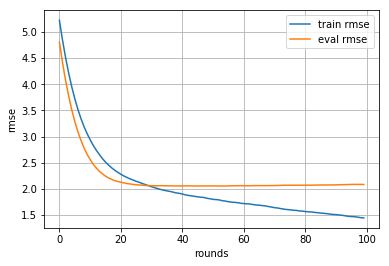

In [8]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

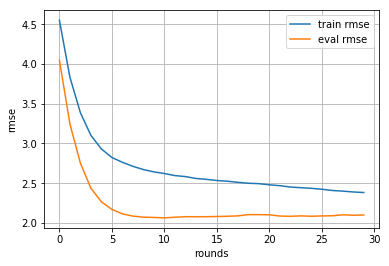

In [13]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

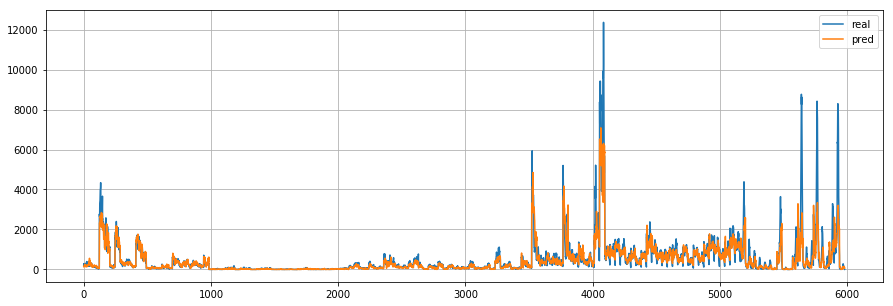

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Clicks'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

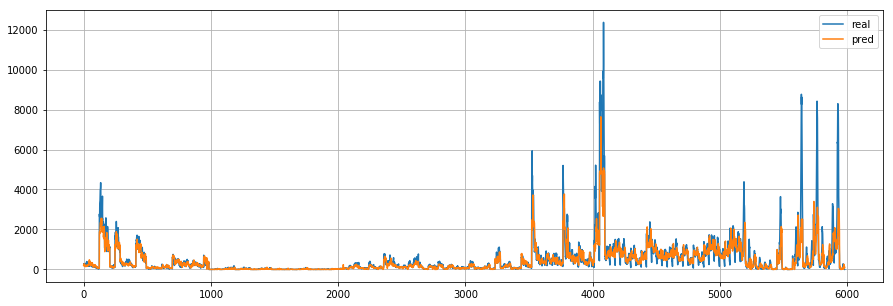

In [14]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Clicks'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

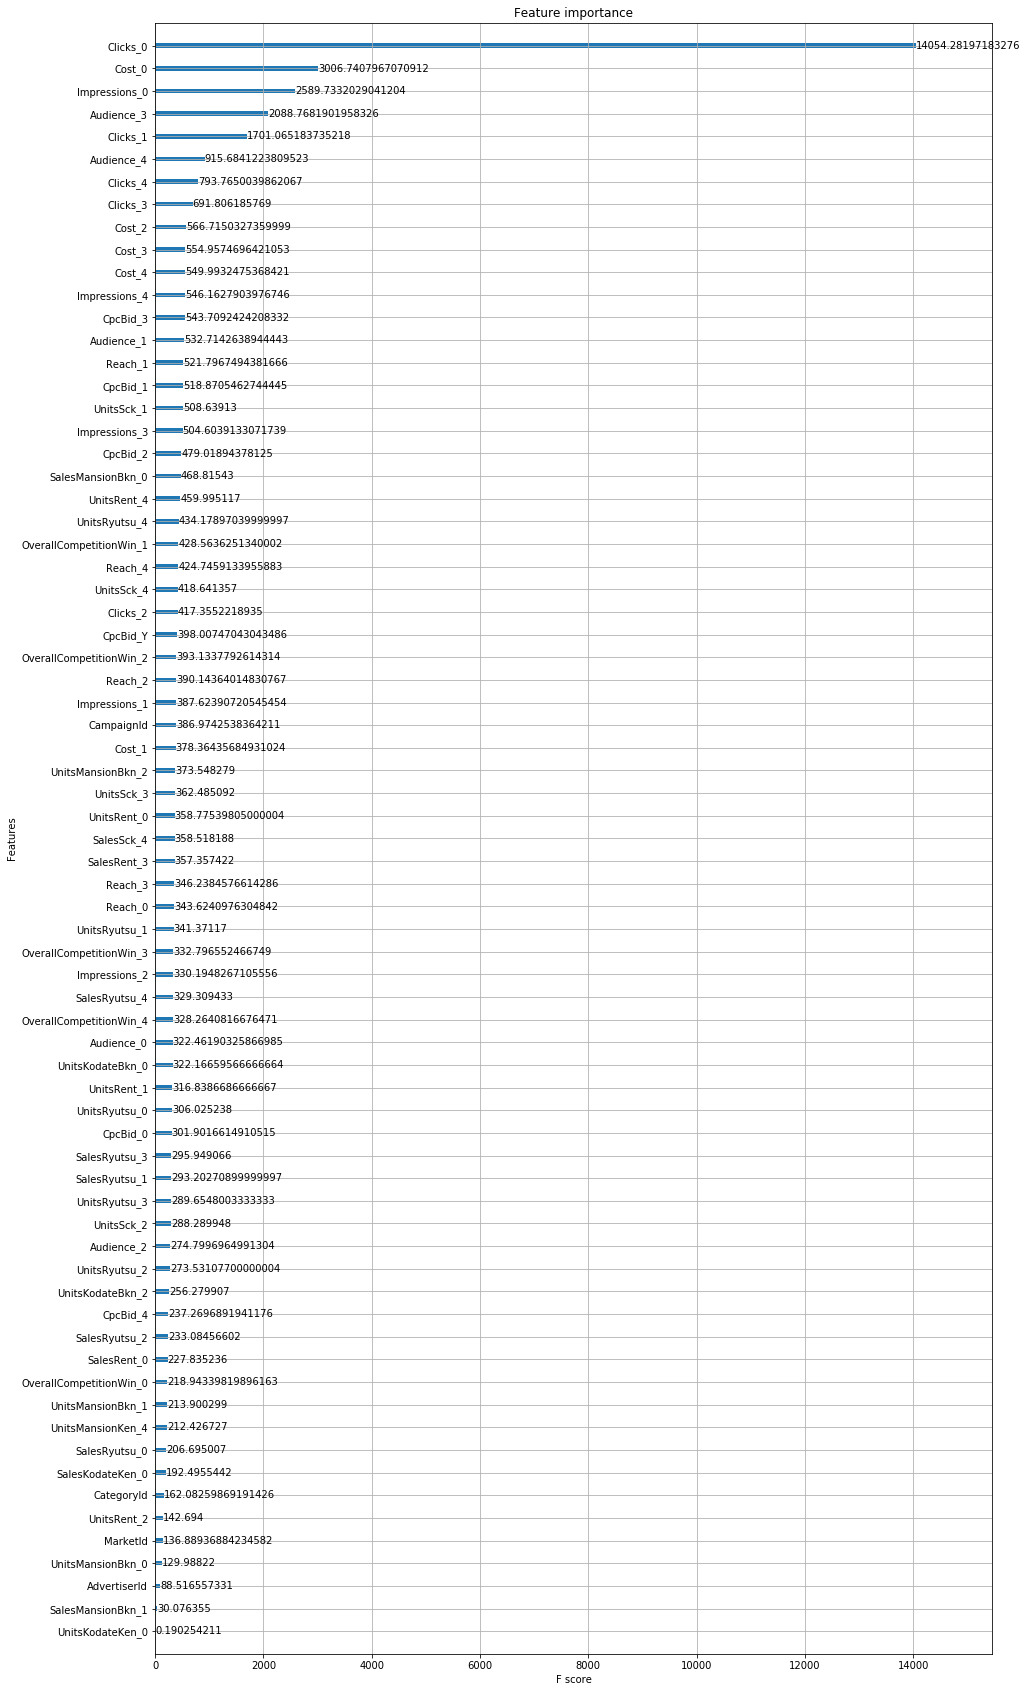

In [15]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Clicks_0',
 'Cost_0',
 'Impressions_0',
 'Audience_3',
 'Clicks_4',
 'CpcBid_3',
 'Audience_4',
 'Clicks_3',
 'Audience_2',
 'Cost_4',
 'Reach_4',
 'CpcBid_1',
 'Audience_1',
 'Reach_2',
 'Reach_1',
 'Audience_0',
 'Reach_0',
 'CpcBid_Y',
 'Impressions_4',
 'Impressions_3',
 'UnitsKodateKen_1',
 'Reach_3',
 'Cost_2',
 'OverallCompetitionWin_3',
 'Impressions_1',
 'CampaignId',
 'CpcBid_2',
 'Cost_3',
 'OverallCompetitionWin_4',
 'Impressions_2',
 'Cost_1',
 'OverallCompetitionWin_2',
 'OverallCompetitionWin_1',
 'Clicks_1',
 'CpcBid_4',
 'SalesRyutsu_2',
 'MarketId',
 'Clicks_2',
 'OverallCompetitionWin_0',
 'UnitsRent_2',
 'CategoryId',
 'CpcBid_0',
 'SalesMansionBkn_4',
 'SalesRyutsu_3',
 'UnitsRyutsu_4',
 'UnitsRyutsu_2',
 'UnitsRyutsu_3',
 'SalesRyutsu_4',
 'UnitsSck_4',
 'UnitsKodateBkn_4',
 'UnitsRyutsu_1',
 'AdvertiserId',
 'SalesMansionBkn_1',
 'SalesKodateKen_3',
 'SalesSck_3',
 'UnitsRyutsu_0',
 'SalesRent_2',
 'SalesRyutsu_1',
 'SalesKodateKen_0',
 'UnitsRent_1',
 'UnitsKo